In [1]:
# two

In [2]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [3]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [4]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [5]:
# optimizer
ga = GA(
    dict(
        m = 50,
        x_rate = 0.5,
        m_rate = 0.5,
        weight_constraint = [-3.,3.],
        radioactive_rating = 0.1,
        grow_factor = 0.1,
        scale_hyperparameter = False,
        regularizer = None))

In [6]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [7]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 2
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [8]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [9]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    

C:\Users\tcumi\github_repo\neural-network\python\ga.py:201: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.9197530864197531, Loss: 0.32686282970287184
Checkpoint 200, Accuracy: 0.9320987654320988, Loss: 0.3077841511479131
Checkpoint 300, Accuracy: 0.9320987654320988, Loss: 0.28742332811708804
Checkpoint 400, Accuracy: 0.9382716049382716, Loss: 0.2721062942787453
Checkpoint 500, Accuracy: 0.9382716049382716, Loss: 0.2534356117248535


In [10]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.6925824  0.01993011 0.28748748]
[1. 0. 0.] <-> [0.9031858  0.08836893 0.00844523]
[0. 0. 1.] <-> [0.06123575 0.00671687 0.93204737]
[0. 0. 1.] <-> [0.6773771  0.02612804 0.29649484]
[1. 0. 0.] <-> [0.9189158  0.06578721 0.01529699]
[1. 0. 0.] <-> [0.8640427  0.12586655 0.01009078]
[0. 1. 0.] <-> [0.73788196 0.2605152  0.00160288]
[1. 0. 0.] <-> [0.9248598  0.04491609 0.03022413]
[1. 0. 0.] <-> [0.83284    0.1638578  0.00330217]
[1. 0. 0.] <-> [0.84796405 0.14763336 0.00440267]
[1. 0. 0.] <-> [0.92620885 0.04307018 0.03072087]
[1. 0. 0.] <-> [0.7442799  0.13484012 0.12087992]
[1. 0. 0.] <-> [0.9219598  0.03779611 0.04024416]
[1. 0. 0.] <-> [0.91321594 0.03827854 0.04850547]
[0. 1. 0.] <-> [0.804099   0.19422328 0.00167772]
[0. 1. 0.] <-> [0.5644521  0.4330487  0.00249912]
[1. 0. 0.] <-> [0.87525815 0.11845757 0.00628425]
[1. 0. 0.] <-> [0.91084534 0.0427901  0.04636446]
[1. 0. 0.] <-> [0.8618802  0.13315669 0.00496316]
[1. 0. 0.] <-> [0.8109406  0.02343401 0.16562542]


In [12]:
# Testing Performance

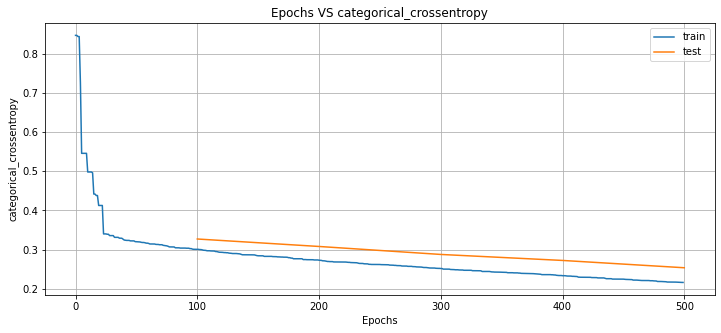

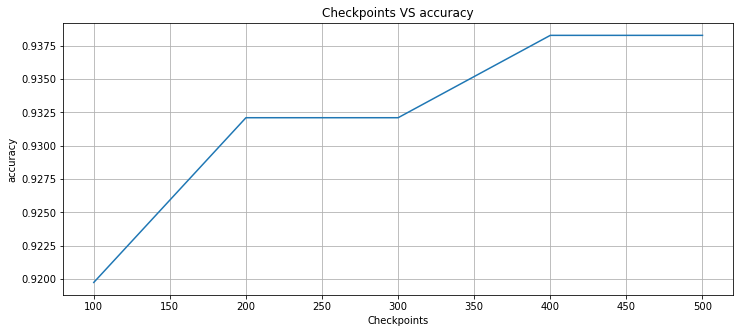

In [13]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [14]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9197530864197531, 'mean_square_error': 0.18424315050745246, 'categorical_crossentropy': 0.32686282970287184, 'precision': 0.8796296296296297, 'recall': 0.8796296296296297, 'f1': 0.8796296296296297, 'essential_metrics': {0: {'tp_hit': 79, 'fp_hit': 12, 'tn_hit': 16, 'fn_hit': 1}, 1: {'tp_hit': 5, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 10}, 2: {'tp_hit': 11, 'fp_hit': 1, 'tn_hit': 94, 'fn_hit': 2}}, 'checkpoint': 100} 


{'accuracy': 0.9320987654320988, 'mean_square_error': 0.16732073370424633, 'categorical_crossentropy': 0.3077841511479131, 'precision': 0.8981481481481481, 'recall': 0.8981481481481481, 'f1': 0.8981481481481481, 'essential_metrics': {0: {'tp_hit': 79, 'fp_hit': 10, 'tn_hit': 18, 'fn_hit': 1}, 1: {'tp_hit': 7, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 8}, 2: {'tp_hit': 11, 'fp_hit': 1, 'tn_hit': 94, 'fn_hit': 2}}, 'checkpoint': 200} 


{'accuracy': 0.9320987654320988, 'mean_square_error': 0.15724485583201375, 'categorical_crossentropy': 0.28742332811708804, 'preci

In [15]:
print(model)

Layer 1
Neuron 0: weights:
[ 2.2469356   0.56138563 -2.9540706  -2.4458034   0.11126941]
 bias: 2.3912906646728516

Neuron 1: weights:
[-0.17243998 -1.9075816  -1.0005566   2.0221374   2.5366654 ]
 bias: -2.550215482711792

Neuron 2: weights:
[-0.47851095  0.5509332   1.3603176  -0.5264241  -2.0707705 ]
 bias: -0.07003305107355118

Neuron 3: weights:
[-1.1623195   2.8669891  -0.28993922 -2.0347486  -2.274787  ]
 bias: -0.1397167444229126

$
Layer 2
Neuron 0: weights:
[ 2.9966028  -1.954481    0.0277383  -0.34758967]
 bias: 0.6412819027900696

Neuron 1: weights:
[-1.068823   0.5706484  1.464813   1.8670471]
 bias: -0.0638515055179596

Neuron 2: weights:
[ 0.15585595  2.3343556  -2.5067725  -2.857751  ]
 bias: 1.8918447494506836

$

